In [ ]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.util import invert

# --- Load image ---
img = cv2.imread("flow_path.jpg")
orig = img.copy()

# --- Preprocess to isolate tubing ---
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Threshold (tune values depending on tubing contrast)
_, mask = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

# Skeletonize (get 1-pixel wide centerline)
skeleton = skeletonize(mask > 0)
skeleton = skeleton.astype(np.uint8) * 255

# --- Extract path coordinates ---
coords = np.column_stack(np.where(skeleton > 0))
# coords are in (row, col) = (y, x)

# Optional: sort coords into a path (naive: nearest neighbor ordering)
path = [coords[0]]
coords = list(map(tuple, coords[1:]))
while coords:
    last = path[-1]
    # find nearest remaining point
    nearest = min(coords, key=lambda c: (c[0]-last[0])**2 + (c[1]-last[1])**2)
    path.append(nearest)
    coords.remove(nearest)

# --- Define ROI parameters ---
roi_size = 20  # window size

# --- Traverse path and measure color ---
colors = []
for (y, x) in path[::10]:  # step every 10 pixels along path
    y1, y2 = max(0, y-roi_size//2), min(img.shape[0], y+roi_size//2)
    x1, x2 = max(0, x-roi_size//2), min(img.shape[1], x+roi_size//2)
    
    roi = orig[y1:y2, x1:x2]
    mean_color = cv2.mean(roi)[:3]  # (B, G, R)
    colors.append(mean_color)

    # Draw ROI for visualization
    cv2.rectangle(orig, (x1, y1), (x2, y2), (0, 0, 255), 1)

# --- Show results ---
cv2.imshow("Path with ROIs", orig)
cv2.imshow("Skeleton", skeleton)
cv2.waitKey(0)
cv2.destroyAllWindows()

# --- Save color data ---
print("Collected", len(colors), "color samples along path")


In [ ]:
import cv2
import numpy as np

# --- Load your tubing image ---
img = cv2.imread("tubing.png")
display = img.copy()

# --- Define path as list of (x, y) coordinates ---
# (You can replace these with the actual tubing path)
path = [
    (50, 100),
    (120, 150),
    (200, 180),
    (280, 220),
    (350, 260)
]

# --- Draw path on image ---
for i in range(len(path) - 1):
    cv2.line(display, path[i], path[i+1], (0, 0, 255), 2)  # red line

# Draw nodes (optional, for clarity)
for pt in path:
    cv2.circle(display, pt, 5, (255, 0, 0), -1)  # blue points

# --- Show image ---
cv2.imshow("Tubing Path", display)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2

points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        if len(points) > 1:
            cv2.line(img, points[-2], points[-1], (0, 0, 255), 2)
        cv2.circle(img, (x, y), 4, (255, 0, 0), -1)
        cv2.imshow("Define Path", img)

# Load image
img = cv2.imread("flow_path.jpg")

cv2.imshow("Define Path", img)
cv2.setMouseCallback("Define Path", click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

print("Path points:", points)


In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("flow_path.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image and click points
plt.imshow(img_rgb)
plt.axis("off")
path = plt.ginput(n=-1, timeout=0)  # unlimited clicks, close figure when done
plt.close()

# Draw path on image
for i in range(len(path) - 1):
    cv2.line(img, (int(path[i][0]), int(path[i][1])),
                  (int(path[i+1][0]), int(path[i+1][1])),
                  (0, 0, 255), 2)
for pt in path:
    cv2.circle(img, (int(pt[0]), int(pt[1])), 4, (255, 0, 0), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("Path points:", path)


In [ ]:
%matplotlib qt

In [ ]:
import cv2
import numpy as np

path_points = []
frozen = False  # To stop updating after pressing Enter

def click_event(event, x, y, flags, param):
    global path_points
    if event == cv2.EVENT_LBUTTONDOWN:
        path_points.append((x, y))

# Open the webcam
cap = cv2.VideoCapture(0)
cv2.namedWindow("Define Path")
cv2.setMouseCallback("Define Path", click_event)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    temp = frame.copy()

    # Draw clicked points and polyline
    if len(path_points) > 0:
        for p in path_points:
            cv2.circle(temp, p, 5, (0, 0, 255), -1)
        if len(path_points) > 1:
            cv2.polylines(temp, [np.array(path_points, np.int32)],
                          isClosed=False, color=(0, 255, 0), thickness=2)

    cv2.imshow("Define Path", temp)
    key = cv2.waitKey(1) & 0xFF

    if key == 13:   # Enter = freeze and save
        frozen = True
        break
    elif key == 27: # Esc = quit without saving
        path_points = []
        break

cap.release()
cv2.destroyAllWindows()

print("Defined path points:", path_points)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Open webcam and grab one frame
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Failed to capture image from webcam")

# Convert to grayscale and preprocess
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

# Edge detection
edges = cv2.Canny(blur, 30, 100)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

output = frame.copy()

if contours:
    # Largest contour = likely the flow path
    contour = max(contours, key=cv2.contourArea)

    # Approximate with polyline
    epsilon = 0.01 * cv2.arcLength(contour, True)
    polyline = cv2.approxPolyDP(contour, epsilon, False)

    # Draw polyline in green
    cv2.drawContours(output, [polyline], -1, (0,255,0), 2)

# Convert BGR → RGB for display
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Show result
plt.figure(figsize=(8,6))
plt.imshow(output_rgb)
plt.title("Detected Flow Path")
plt.axis("off")
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            trajectory.append((cx, cy))
            cv2.circle(frame, (cx, cy), 6, (0, 0, 255), -1)

    # Draw trajectory as green polyline
    if len(trajectory) > 1:
        cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

    # Convert for matplotlib (BGR -> RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Show live in Jupyter
    clear_output(wait=True)
    plt.imshow(frame_rgb)
    plt.title("Flow Path Tracking (Press 'q' in notebook to stop)")
    plt.axis("off")
    display(plt.gcf())

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_frame = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            trajectory.append((cx, cy))
            cv2.circle(frame, (cx, cy), 6, (0, 0, 255), -1)

    # Draw trajectory as green polyline
    if len(trajectory) > 1:
        cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

    # Save last frame for final snapshot
    last_frame = frame.copy()

    # Convert for matplotlib (BGR -> RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Show live in Jupyter
    clear_output(wait=True)
    plt.imshow(frame_rgb)
    plt.title("Flow Path Tracking (Press 'q' to stop)")
    plt.axis("off")
    display(plt.gcf())

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

# Show final snapshot
if last_frame is not None:
    final_rgb = cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(final_rgb)
    plt.title("Final Flow Path")
    plt.axis("off")
    plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_capture_time = 0  # track last time we saved a point
capture_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Only save point every 1 second
            current_time = time.time()
            if current_time - last_capture_time >= capture_interval:
                trajectory.append((cx, cy))
                last_capture_time = current_time

            # Always draw red dot live
            cv2.circle(frame, (cx, cy), 6, (0, 0, 255), -1)

    # Draw trajectory as green polyline
    if len(trajectory) > 1:
        cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

    # Convert for matplotlib (BGR -> RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Show live in Jupyter
    clear_output(wait=True)
    plt.imshow(frame_rgb)
    plt.title("Flow Path Tracking (Press 'q' in notebook to stop)")
    plt.axis("off")
    display(plt.gcf())

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_update_time = 0
update_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Always mark detected point (runs every frame)
            cv2.circle(frame, (cx, cy), 6, (0, 0, 255), -1)

            # Add every frame to trajectory (30 fps capture)
            trajectory.append((cx, cy))

    # Only refresh the notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        if len(trajectory) > 1/30:
            cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Tracking (30fps tracking, 1Hz display)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_update_time = 0
update_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get largest contour (plug body)
        c = max(contours, key=cv2.contourArea)

        # Approximate contour to reduce noise
        epsilon = 0.01 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)

        # Take multiple points along the contour
        points = [tuple(pt[0]) for pt in approx]

        # Add them all to trajectory
        trajectory.extend(points)

        # Draw red dots for each sampled point
        for (x, y) in points:
            cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)

    # Only refresh the notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        if len(trajectory) > 1:
            cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Tracking (multiple points per frame)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_update_time = 0
update_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get largest contour (plug body)
        c = max(contours, key=cv2.contourArea)

        # Flatten contour array
        pts = c.reshape(-1, 2)

        if len(pts) >= 3:
            start = tuple(pts[0])
            middle = tuple(pts[len(pts) // 2])
            end = tuple(pts[-1])

            key_points = [start, middle, end]

            # Add them to trajectory
            trajectory.extend(key_points)

            # Draw red dots on start, middle, end
            for (x, y) in key_points:
                cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)

    # Only refresh the notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        if len(trajectory) > 1:
            cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Tracking (start, middle, end points per frame)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_update_time = 0
update_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get largest contour (plug body)
        c = max(contours, key=cv2.contourArea)
        pts = c.reshape(-1, 2)

        if len(pts) >= 2:
            # Start and End from contour
            start = tuple(pts[0])
            end = tuple(pts[-1])

            # Middle = centroid of contour
            M = cv2.moments(c)
            if M["m00"] > 0:
                middle = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            else:
                middle = tuple(pts[len(pts) // 2])  # fallback

            key_points = [start, middle, end]

            # Add them to trajectory
            trajectory.extend(key_points)

            # Draw red dots on start, middle, end
            for (x, y) in key_points:
                cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)

    # Only refresh the notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        if len(trajectory) > 1:
            cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Tracking (start, centroid, end per frame)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store plug positions
last_update_time = 0
update_interval = 1.0  # seconds
prev_centroid = None  # for estimating motion direction

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get largest contour (plug body)
        c = max(contours, key=cv2.contourArea)
        pts = c.reshape(-1, 2)

        # Compute centroid
        M = cv2.moments(c)
        if M["m00"] > 0:
            centroid = np.array([int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])])
        else:
            centroid = np.mean(pts, axis=0).astype(int)

        if prev_centroid is None:
            prev_centroid = centroid

        # Motion vector (current - previous)
        motion = centroid - prev_centroid
        motion_norm = np.linalg.norm(motion)

        if motion_norm > 1e-6:  # avoid divide by zero
            motion_dir = motion / motion_norm

            # Project contour points onto motion vector
            projections = np.dot(pts - centroid, motion_dir)

            start = tuple(pts[np.argmin(projections)])  # furthest behind
            end = tuple(pts[np.argmax(projections)])    # furthest ahead
        else:
            # fallback if no motion
            start = tuple(pts[pts[:, 0].argmin()])
            end = tuple(pts[pts[:, 0].argmax()])

        key_points = [start, tuple(centroid), end]

        # Add them to trajectory
        trajectory.extend(key_points)

        # Draw red dots on start, middle, end
        for (x, y) in key_points:
            cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)

        prev_centroid = centroid  # update motion reference

    # Only refresh the notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        if len(trajectory) > 1:
            cv2.polylines(frame, [np.array(trajectory, np.int32)], False, (0, 255, 0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Tracking (start, centroid, end by motion direction)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory_start = []
trajectory_centroid = []
trajectory_end = []

last_update_time = 0
update_interval = 1.0  # seconds
prev_centroid = None  # for estimating motion direction

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak if needed for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of the blue object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get largest contour (plug body)
        c = max(contours, key=cv2.contourArea)
        pts = c.reshape(-1, 2)

        # Compute centroid
        M = cv2.moments(c)
        if M["m00"] > 0:
            centroid = np.array([int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])])
        else:
            centroid = np.mean(pts, axis=0).astype(int)

        if prev_centroid is None:
            prev_centroid = centroid

        # Motion vector (current - previous)
        motion = centroid - prev_centroid
        motion_norm = np.linalg.norm(motion)

        if motion_norm > 1e-6:  # avoid divide by zero
            motion_dir = motion / motion_norm
            projections = np.dot(pts - centroid, motion_dir)
            start = tuple(pts[np.argmin(projections)])  # furthest behind
            end = tuple(pts[np.argmax(projections)])    # furthest ahead
        else:
            # fallback if no motion
            start = tuple(pts[pts[:, 0].argmin()])
            end = tuple(pts[pts[:, 0].argmax()])

        # Store trajectories separately
        trajectory_start.append(start)
        trajectory_centroid.append(tuple(centroid))
        trajectory_end.append(end)

        # Draw red dots for current frame's key points
        for (x, y) in [start, tuple(centroid), end]:
            cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)

        prev_centroid = centroid

    # Only refresh the notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        # Draw smooth polylines for each trajectory
        if len(trajectory_start) > 1:
            cv2.polylines(frame, [np.array(trajectory_start, np.int32)], False, (255, 0, 0), 2)  # blue
        if len(trajectory_centroid) > 1:
            cv2.polylines(frame, [np.array(trajectory_centroid, np.int32)], False, (0, 255, 0), 2)  # green
        if len(trajectory_end) > 1:
            cv2.polylines(frame, [np.array(trajectory_end, np.int32)], False, (0, 0, 255), 2)  # red

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Tracking (separate start, centroid, end paths)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()



KeyboardInterrupt



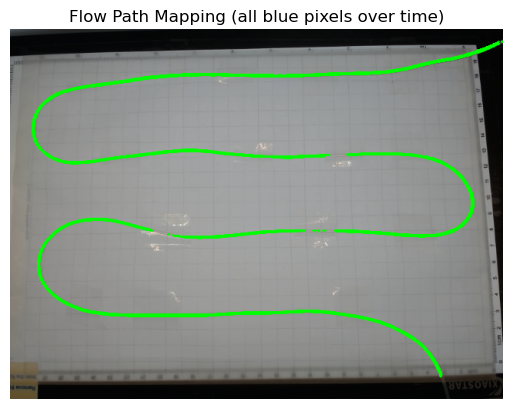

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory = []  # store all detected blue points
last_update_time = 0
update_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find all blue pixels
    ys, xs = np.where(mask > 0)
    for (x, y) in zip(xs, ys):
        trajectory.append((x, y))  # save every blue pixel location

    # Draw trail (green)
    for (x, y) in trajectory:
        cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)

    # Update notebook view once per second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Flow Path Mapping (all blue pixels over time)")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Open webcam
cap = cv2.VideoCapture(0)

trajectory_mask = None
last_update_time = 0
update_interval = 1.0  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Initialize storage mask once
    if trajectory_mask is None:
        trajectory_mask = np.zeros_like(mask)

    # Add detected pixels to cumulative mask
    trajectory_mask = cv2.bitwise_or(trajectory_mask, mask)

    # Only update view every second
    current_time = time.time()
    if current_time - last_update_time >= update_interval:
        # Copy frame to draw on
        display_frame = frame.copy()

        # Extract contour of the accumulated path
        contours, _ = cv2.findContours(trajectory_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Get largest contour (assume tubing path is main shape)
            c = max(contours, key=cv2.contourArea)

            # Approximate it to smooth
            epsilon = 0.01 * cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon, False)

            # Draw contour as green line
            cv2.polylines(display_frame, [approx], False, (0, 255, 0), 2)

        # Show in notebook
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title("Full Path Reconstruction")
        plt.axis("off")
        display(plt.gcf())

        last_update_time = current_time

    # Stop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Open webcam
cap = cv2.VideoCapture(0)

trajectory_mask = None  # store all blue pixels over time
collecting = True

while collecting:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define blue range (tweak for your plug color)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Initialize cumulative mask once
    if trajectory_mask is None:
        trajectory_mask = np.zeros_like(mask)

    # Add detected pixels to cumulative mask
    trajectory_mask = cv2.bitwise_or(trajectory_mask, mask)

    # Show live video (just for monitoring, not joining points yet)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.imshow(frame_rgb)
    plt.title("Collecting points... (press 'q' to stop)")
    plt.axis("off")
    display(plt.gcf())

    # Stop collecting if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        collecting = False

cap.release()

# ---------------------------------
# After collection: connect points
# ---------------------------------
final_frame = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)

# Extract contour of accumulated path
contours, _ = cv2.findContours(trajectory_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Get largest contour (assume tubing path is main shape)
    c = max(contours, key=cv2.contourArea)

    # Approximate it to smooth
    epsilon = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, False)

    # Draw contour as green polyline
    cv2.polylines(final_frame, [approx], False, (0, 255, 0), 2)

# Show the final snake-like path
final_rgb = cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB)
clear_output(wait=True)
plt.imshow(final_rgb)
plt.title("Final Path (joined after stopping)")
plt.axis("off")
plt.show()
